In [36]:
import os
import pathlib
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# kaggle
# INPUT_PATH = '../input/paddy-disease-classification/'
INPUT_PATH = './paddy-disease-classification/'
TRAIN_PATH = INPUT_PATH + 'train_images'
TEST_PATH = INPUT_PATH + 'test_images'

In [3]:
image_count = len(list(pathlib.Path(TRAIN_PATH).glob('*/*.jpg')))
print(image_count)

10407


In [27]:
SEED = 12
HEIGHT = 224
WIDTH = 224
BATCH_SIZE = 32
EPOCHS = 10

In [6]:
training_set = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset='training',
    shuffle=True,
    seed=SEED,
    image_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE
)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.


In [7]:
val_set = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE
)

Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [8]:
class_names = training_set.class_names
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


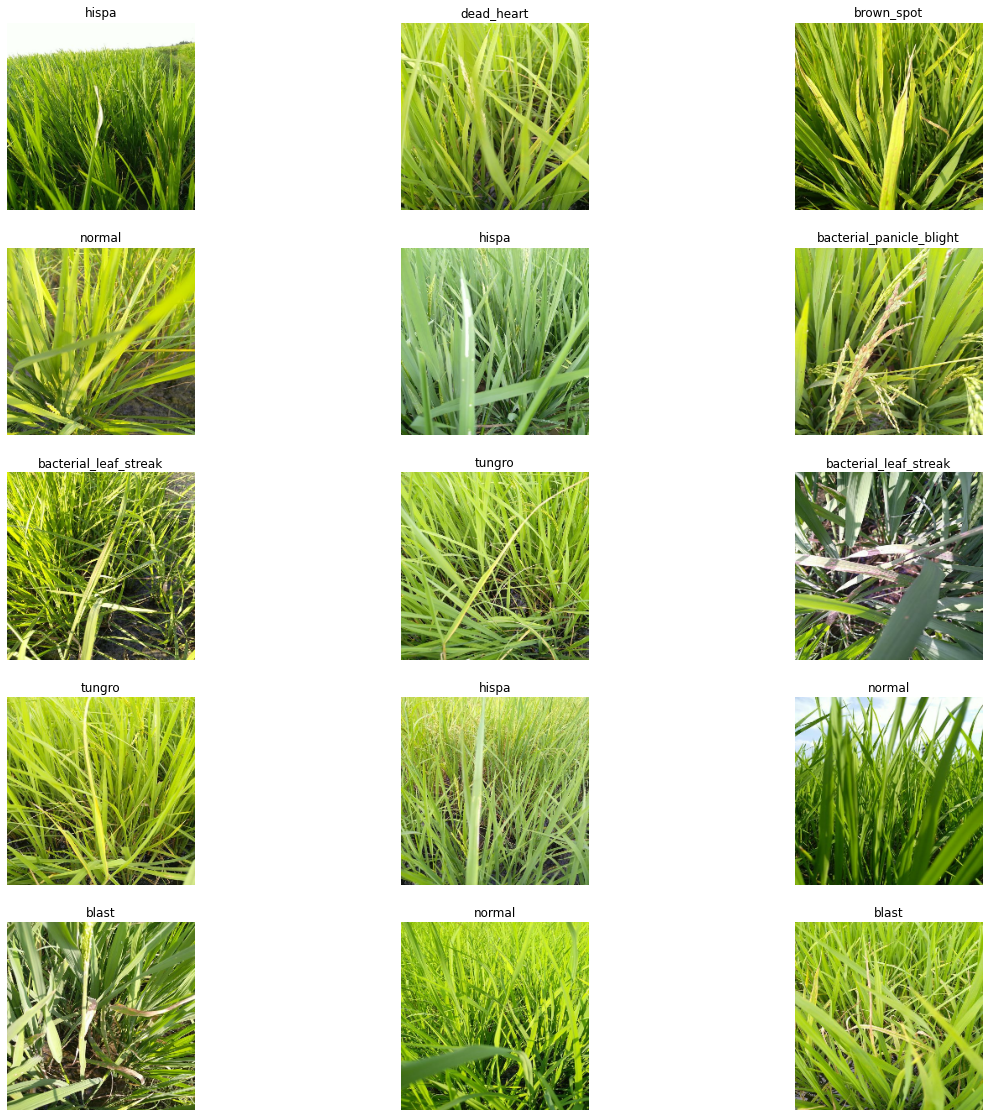

In [10]:
plt.figure(figsize=(20, 20))
for images, labels in training_set.take(1):
    for i in range(15):
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.show()

In [13]:
inception = InceptionV3(
    input_shape=[HEIGHT, WIDTH, 3],
    weights='imagenet',
    include_top=False
)

87910968/87910968 [==============================] - 2s 0us/step


In [14]:
for layer in inception.layers:
    layer.trainable = False

In [16]:
x = Flatten()(inception.output)

In [18]:
folders = glob(TRAIN_PATH + '/*')

In [20]:
prediction = Dense(len(folders), activation='softmax')(x)

In [22]:
model = Model(inputs=inception.input, outputs=prediction)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
train_ds = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 8330 images belonging to 10 classes.


In [26]:
val_ds = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 2077 images belonging to 10 classes.


In [28]:
tf.config.run_functions_eagerly(True)
r = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=EPOCHS
)

Epoch 1/10


c:\Users\posky\anaconda3\envs\tf20\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


261/261 [==============================] - 180s 676ms/step - loss: 4.2471 - accuracy: 0.4643 - val_loss: 3.9520 - val_accuracy: 0.5686
Epoch 2/10
261/261 [==============================] - 81s 311ms/step - loss: 3.2654 - accuracy: 0.5860 - val_loss: 4.0132 - val_accuracy: 0.5686
Epoch 3/10
261/261 [==============================] - 80s 305ms/step - loss: 3.0899 - accuracy: 0.6339 - val_loss: 3.4383 - val_accuracy: 0.6351
Epoch 4/10
261/261 [==============================] - 81s 309ms/step - loss: 2.5284 - accuracy: 0.6903 - val_loss: 3.2008 - val_accuracy: 0.6456
Epoch 5/10
261/261 [==============================] - 83s 317ms/step - loss: 3.0749 - accuracy: 0.6780 - val_loss: 3.2440 - val_accuracy: 0.6408
Epoch 6/10
261/261 [==============================] - 80s 308ms/step - loss: 2.4697 - accuracy: 0.7208 - val_loss: 2.6990 - val_accuracy: 0.6914
Epoch 7/10
261/261 [==============================] - 80s 308ms/step - loss: 2.5213 - accuracy: 0.7286 - val_loss: 4.0076 - val_accuracy: 0.

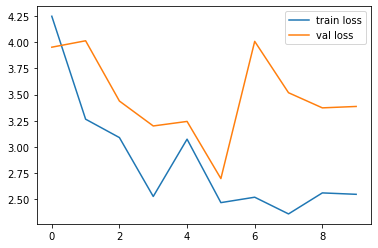

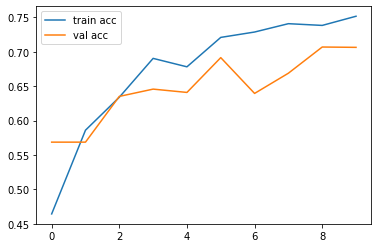

In [29]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [34]:
test_ds = test_datagen.flow_from_directory(
    directory=TEST_PATH,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    classes=['.'],
    class_mode=None,
    shuffle=False
)

probabilities = model.predict(test_ds, verbose=1)

Found 3469 images belonging to 1 classes.
  1/109 [..............................] - ETA: 15s

c:\Users\posky\anaconda3\envs\tf20\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


109/109 [==============================] - 9s 86ms/step


In [33]:
predicted_class_indices = np.argmax(probabilities, axis=1)

labels = (train_ds.class_indices)
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

['bacterial_leaf_blight',
 'normal',
 'blast',
 'blast',
 'blast',
 'bacterial_leaf_blight',
 'dead_heart',
 'bacterial_leaf_streak',
 'hispa',
 'normal',
 'dead_heart',
 'hispa',
 'normal',
 'dead_heart',
 'normal',
 'blast',
 'tungro',
 'hispa',
 'dead_heart',
 'dead_heart',
 'dead_heart',
 'brown_spot',
 'bacterial_leaf_blight',
 'dead_heart',
 'blast',
 'hispa',
 'blast',
 'bacterial_leaf_blight',
 'dead_heart',
 'bacterial_leaf_streak',
 'hispa',
 'dead_heart',
 'brown_spot',
 'brown_spot',
 'dead_heart',
 'bacterial_leaf_blight',
 'bacterial_leaf_blight',
 'downy_mildew',
 'dead_heart',
 'hispa',
 'tungro',
 'brown_spot',
 'bacterial_leaf_streak',
 'hispa',
 'bacterial_leaf_blight',
 'brown_spot',
 'blast',
 'brown_spot',
 'bacterial_panicle_blight',
 'dead_heart',
 'blast',
 'blast',
 'blast',
 'normal',
 'hispa',
 'hispa',
 'hispa',
 'blast',
 'bacterial_leaf_blight',
 'hispa',
 'dead_heart',
 'blast',
 'normal',
 'bacterial_leaf_blight',
 'brown_spot',
 'brown_spot',
 'brown_s

In [37]:
sub = pd.read_csv(f'{INPUT_PATH}sample_submission.csv')
sub['label'] = predictions

# local
sub.to_csv('InceptionV3_submission.csv', index=False)

# kaggle
# sub.to_csv('submission.csv', index=False)